In [4]:
import csv
import sys
import requests
import skimage.io
import os
import glob
import pickle
import time

from IPython.display import display, Image, HTML
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image as kimage
import numpy as np
import pandas as pd
import scipy.sparse as sp
import skimage.io

# sys.path.append('../')
import helpers

Using TensorFlow backend.


In [5]:
rand_img = np.random.choice(glob.glob('/Users/gina/shoes/shoes/main_shoes/*.jpg'))

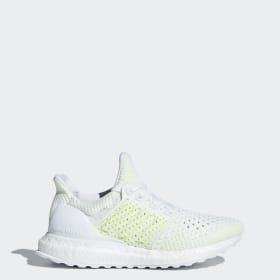

In [6]:
Image(filename=rand_img)

In [7]:
img = skimage.io.imread(rand_img)
img.shape

(280, 280, 3)

In [8]:
img = kimage.load_img(rand_img, target_size=(224, 224))
x = kimage.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(x.shape)

(1, 224, 224, 3)


In [9]:
model = VGG16(include_top=False, weights='imagenet')

In [10]:
pred = model.predict(x)
print(pred.shape)
print(pred.ravel().shape)

(1, 7, 7, 512)
(25088,)


In [11]:
%%timeit -n5
pred = model.predict(x)

289 ms ± 3.7 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [13]:
# Grab relevant filenames
get_mid = lambda x: x.split(os.path.sep)[-1].split('_')[0]
fnames = glob.glob('/Users/gina/shoes/shoes/main_shoes/*.jpg')
fnames = [f for f in fnames]

idx_to_mid = {}
batch_size = 500
min_idx = 0
max_idx = min_idx + batch_size
total_max = len(fnames)
n_dims = 25088
#pred.ravel().shape[0]
px = 224

# Initialize predictions matrix
preds = sp.lil_matrix((len(fnames), n_dims))

while min_idx < total_max - 1:
    t0 = time.time()
    
    X = np.zeros(((max_idx - min_idx), px, px, 3))
    
    # For each file in batch, 
    # load as row into X
    for i in range(min_idx, max_idx):
        fname = fnames[i]
        mid = get_mid(fname)
        idx_to_mid[i] = mid
        img = kimage.load_img(fname, target_size=(px, px))
        img_array = kimage.img_to_array(img)
        X[i - min_idx, :, :, :] = img_array
        if i % 200 == 0 and i != 0:
            t1 = time.time()
            print('{}: {}'.format(i, (t1 - t0) / i))
            t0 = time.time()
    max_idx = i
    t1 = time.time()
    print('{}: {}'.format(i, (t1 - t0) / i))
    
    print('Preprocess input')
    t0 = time.time()
    X = preprocess_input(X)
    t1 = time.time()
    print('{}'.format(t1 - t0))
    
    print('Predicting')
    t0 = time.time()
    these_preds = model.predict(X)
    shp = ((max_idx - min_idx) + 1, n_dims)
    
    # Place predictions inside full preds matrix.
    preds[min_idx:max_idx + 1, :] = these_preds.reshape(shp)
    t1 = time.time()
    print('{}'.format(t1 - t0))
    
    min_idx = max_idx
    max_idx = np.min((max_idx + batch_size, total_max))

200: 0.0033551812171936034
400: 0.0017356526851654052
499: 0.000682102176612747
Preprocess input
0.2121589183807373
Predicting
140.63612389564514
600: 0.0006002298990885417
800: 0.000778413712978363
998: 0.0006508476031806044
Preprocess input
0.14566302299499512
Predicting
141.69146084785461
1000: 2.962493896484375e-05
1200: 0.0005049284299214681
1400: 0.00045412489346095494
1497: 0.0002121629122502818
Preprocess input
0.13828086853027344
Predicting
138.51496505737305
1600: 0.0001907336711883545
1800: 0.00027863343556722007
1996: 0.00028986479333025183
Preprocess input
0.13826870918273926
Predicting
138.10948777198792
2000: 1.9701480865478516e-05
2200: 0.00026069955392317337
2400: 0.00020396918058395385
2495: 0.00010798469574035767
Preprocess input
0.139024019241333
Predicting
140.46342086791992
2563: 7.403152695029591e-05
Preprocess input
0.01919698715209961
Predicting
18.856544971466064


In [14]:
def cosine_similarity(ratings):
    sim = ratings.dot(ratings.T)
    if not isinstance(sim, np.ndarray):
        sim = sim.toarray()
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [15]:
pred = preds.tocsr()
sim = cosine_similarity(pred)

In [16]:
from PIL import Image
import math

image_name = "5c3c4395ac05eee21b472bc61c8d529b61549b3e.jpg"
image_idx = list(filter(lambda x: x[1] == image_name, idx_to_mid.items()))[0][0]
row = sim[image_idx, :]
new_img = Image.new('RGB', (1025, 425), "#f8fafc")
i = 0
for x in np.argsort(-row)[:10]:
    print(idx_to_mid[x])
    img = Image.open("main_shoes/"+idx_to_mid[x])
    img.thumbnail((200, 200))
    pos = ((i % 5) * 210, int(math.floor(i / 5.0) * 210))
    i += 1
    new_img.paste(img, pos)
new_img.show()

5c3c4395ac05eee21b472bc61c8d529b61549b3e.jpg
2bcc6c443a9c43678ade633c65f9016a43ee3209.jpg
c5b857e197a5f46af42c2f0b42f65d4ada20f229.jpg
8bc94ce5ba67390f0192899391d14f8664d74947.jpg
07f0df5e713de34e887956af61e4cf78f4bbe430.jpg
6dfef23a4c723456447866e8101c6d84d5d44dfa.jpg
a6c27974b6573076e5240523e47ab915bdd75edb.jpg
d5d4a7953cf195a5c9e593d73833405a1fa1cab8.jpg
69a2366348591f9a3ca4d493b527fdf9b904e130.jpg
ff4b6097edffdb0c0974de05df2d91430e36dfbb.jpg


In [17]:
import pickle
pickle.dump(sim, open('similarity_matrix.pkl', 'wb'))
pickle.dump(idx_to_mid, open('file_idx.pkl', 'wb'))

In [18]:
import pickle
from PIL import Image
import math
sim = pickle.load(open('similarity_matrix.pkl', 'rb'))
idx_to_mid = pickle.load(open('file_idx.pkl', 'rb'))
image_name = "5c3c4395ac05eee21b472bc61c8d529b61549b3e.jpg"
image_idx = list(filter(lambda x: x[1] == image_name, idx_to_mid.items()))[0][0]
row = sim[image_idx, :]
new_img = Image.new('RGB', (1025, 425), "#f8fafc")
i = 0
for x in np.argsort(-row)[:10]:
    print(idx_to_mid[x])
    img = Image.open("main_shoes/"+idx_to_mid[x])
    img.thumbnail((200, 200))
    pos = ((i % 5) * 210, int(math.floor(i / 5.0) * 210))
    i += 1
    new_img.paste(img, pos)
new_img.show()

5c3c4395ac05eee21b472bc61c8d529b61549b3e.jpg
2bcc6c443a9c43678ade633c65f9016a43ee3209.jpg
c5b857e197a5f46af42c2f0b42f65d4ada20f229.jpg
8bc94ce5ba67390f0192899391d14f8664d74947.jpg
07f0df5e713de34e887956af61e4cf78f4bbe430.jpg
6dfef23a4c723456447866e8101c6d84d5d44dfa.jpg
a6c27974b6573076e5240523e47ab915bdd75edb.jpg
d5d4a7953cf195a5c9e593d73833405a1fa1cab8.jpg
69a2366348591f9a3ca4d493b527fdf9b904e130.jpg
ff4b6097edffdb0c0974de05df2d91430e36dfbb.jpg
